In [33]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import numpy 

from numpy import array

In [2]:
#Skup podataka sadrži podatke na svakih pola sata, zbog toga mnozimo podatke sa 48 kako bi dobili u danima
input_for_prediction = 48*3 #Označava koliko istorijskih podataka (redova) nam je potrebno da bi prediktovali naredni
#U ovom primeru koristimo podatke za ptrethodna tri dana da bi izvršili predikciju temperature za narednih pola sata 
train_days = 400*48  # Uzimamo podatke od 400 dana za trening 
testing_days = 120*48 # Uzimamo podatke od 120 dana za predikciju 
epochs_num = 25 # broj epoha

In [4]:
#Skup podataka
dataset = pd.read_csv('ukupno.csv')

In [5]:
#delimo skup podataka na trening i test podatke 
train_set = dataset[0:train_days].reset_index(drop=True)
test_set = dataset[train_days: train_days+testing_days].reset_index(drop=True)
#Ostavljamo samo kolonu sa temperaturom koja je zabaležena u Beogradu
training_set = train_set.iloc[:, 1:2].values
testing_set = test_set.iloc[:, 1:2].values

In [6]:
training_set

array([[ 2],
       [ 2],
       [ 2],
       ...,
       [14],
       [14],
       [14]], dtype=int64)

In [7]:
#Normalizacija podataka na vrenosti između 0 i 1
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
testing_set_scaled = sc.fit_transform(testing_set)

C:\Users\Ivic\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [8]:
#Razdvajamo podatke tako da koristimo broj kojem je jednaka promenljiva input_for_prediction kako bismo dobili izlaz 
# i ide do vrenosti end_ix kao ulazni podaci
# end_ix kao izlazni podatak za navedene ulazne podatke 
def data_split(sequence, input_for_prediction):
    X = []
    y = []
    for i in range(len(sequence)):
        end_ix = i + input_for_prediction
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [9]:
#Pozivamo gorespomenutu funkciju kako bi dobili trening i test ulazne i očekivane izlaze
X_train, y_train = data_split(training_set_scaled, input_for_prediction)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test, y_test = data_split(testing_set_scaled, input_for_prediction)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [10]:
# Single cell LSTM
# Kreiranje i treniranje LSTM modela upotrebom Keras biblioteke
modelSCLSTM = Sequential()
modelSCLSTM.add(LSTM(units = 50, activation='relu',input_shape = (X_train.shape[1], X_train.shape[2])))
modelSCLSTM.add(Dense(1))
modelSCLSTM.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = modelSCLSTM.fit(X_train, y_train, epochs = epochs_num, batch_size = 32)
loss = history.history['loss']
epochs_num = range(len(loss))

Epoch 1/25
19056/19056 [==============================] - 60s 3ms/step - loss: 0.0085
Epoch 2/25
19056/19056 [==============================] - 48s 2ms/step - loss: 5.9818e-04
Epoch 3/25
19056/19056 [==============================] - 35s 2ms/step - loss: 4.3278e-04
Epoch 4/25
19056/19056 [==============================] - 36s 2ms/step - loss: 3.6954e-04
Epoch 5/25
19056/19056 [==============================] - 36s 2ms/step - loss: 3.4423e-04
Epoch 6/25
19056/19056 [==============================] - 36s 2ms/step - loss: 3.1121e-04
Epoch 7/25
19056/19056 [==============================] - 36s 2ms/step - loss: 3.0370e-04
Epoch 8/25
19056/19056 [==============================] - 35s 2ms/step - loss: 2.9390e-04
Epoch 9/25
19056/19056 [==============================] - 35s 2ms/step - loss: 2.8784e-04
Epoch 10/25
19056/19056 [==============================] - 36s 2ms/step - loss: 2.8167e-04
Epoch 11/25
19056/19056 [==============================] - 36s 2ms/step - loss: 2.7779e-04
Epoch 12/25


In [11]:
# Predikcija vrednosti na osnovu podataka za testiranje
y_predictedSCLSTM = modelSCLSTM.predict(X_test)

In [12]:
y_predictedSCLSTM

array([[0.5243654 ],
       [0.5265657 ],
       [0.55185956],
       ...,
       [0.3201764 ],
       [0.32921913],
       [0.3538004 ]], dtype=float32)

In [13]:
# Vracanje vrednosti u originalne vrednosti ('obrnuta normalizacija')
y_predicted_descaledSCLSTM = sc.inverse_transform(y_predictedSCLSTM)
y_train_descaledSCLSTM = sc.inverse_transform(y_train)
y_test_descaledSCLSTM = sc.inverse_transform(y_test)
y_predSCLSTM = y_predictedSCLSTM.ravel()
y_predSCLSTM = [round(yx, 2) for yx in y_predSCLSTM]
y_testedSCLSTM = y_test.ravel()

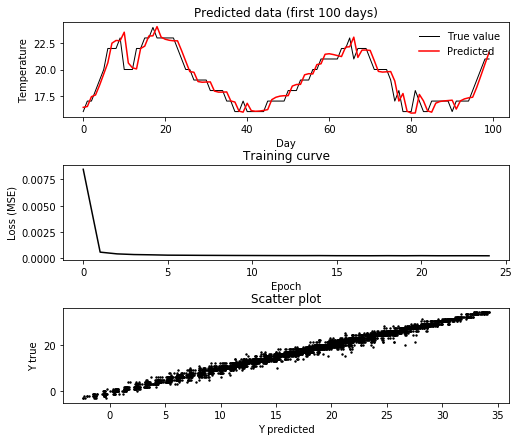

In [15]:
#Grafički prikatz rezultata
plt.figure(figsize=(8,7))


plt.subplot(3, 1, 1)
plt.plot(y_test_descaledSCLSTM[0:100], color = 'black', linewidth=1, label = 'True value')
plt.plot(y_predicted_descaledSCLSTM[0:100], color = 'red', label = 'Predicted')
plt.legend(frameon=False)
plt.ylabel("Temperature")
plt.xlabel("Day")
plt.title("Predicted data (first 100 days)")

plt.subplot(3, 1, 2)
plt.plot(epochs_num, loss, color='black')
plt.ylabel("Loss (MSE)")
plt.xlabel("Epoch")
plt.title("Training curve")

plt.subplot(3, 1, 3)
plt.scatter(y_predicted_descaledSCLSTM, y_test_descaledSCLSTM, s=2, color='black')
plt.ylabel("Y true")
plt.xlabel("Y predicted")
plt.title("Scatter plot")

plt.subplots_adjust(hspace =
                    0.5, wspace=0.3)

plt.savefig("tempPredictionSCLSTM.png",  bbox_inches = "tight")


plt.show()

In [17]:
#Srednja kvadratna i srednja apsolutna greška 
mseSCLSTM = metrics.mean_squared_error(y_test_descaledSCLSTM, y_predicted_descaledSCLSTM)
maeSCLSTM = metrics.mean_absolute_error(y_test_descaledSCLSTM, y_predicted_descaledSCLSTM)
print("mse SCLSTM=" + str(round(mseSCLSTM,2)))
print("mae SCLSTM=" + str(round(maeSCLSTM,2)))

mse SCLSTM=0.74
mae SCLSTM=0.61


In [20]:
# Kreiranje i treniranje  Stacked LSTM modela upotrebom Keras biblioteke
modelSLSTM = Sequential()
modelSLSTM.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
modelSLSTM.add(LSTM(50, activation='relu'))
modelSLSTM.add(Dense(1))
modelSLSTM.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = modelSLSTM.fit(X_train, y_train, epochs = 25, batch_size = 32)
loss = history.history['loss']
epochs_num = range(len(loss))

Epoch 1/25
19056/19056 [==============================] - 56s 3ms/step - loss: 0.0122
Epoch 2/25
19056/19056 [==============================] - 56s 3ms/step - loss: 8.2428e-04
Epoch 3/25
19056/19056 [==============================] - 56s 3ms/step - loss: 6.1200e-04
Epoch 4/25
19056/19056 [==============================] - 56s 3ms/step - loss: 4.9739e-04
Epoch 5/25
19056/19056 [==============================] - 55s 3ms/step - loss: 4.2906e-04
Epoch 6/25
19056/19056 [==============================] - 55s 3ms/step - loss: 3.8834e-04
Epoch 7/25
19056/19056 [==============================] - 55s 3ms/step - loss: 3.3218e-04
Epoch 8/25
19056/19056 [==============================] - 55s 3ms/step - loss: 3.3006e-04
Epoch 9/25
19056/19056 [==============================] - 57s 3ms/step - loss: 3.1807e-04
Epoch 10/25
19056/19056 [==============================] - 57s 3ms/step - loss: 3.0297e-04
Epoch 11/25
19056/19056 [==============================] - 57s 3ms/step - loss: 2.9997e-04
Epoch 12/25


In [21]:
# Predikcija vrednosti na osnovu podataka za testiranje
y_predictedSLSTM = modelSLSTM.predict(X_test)

In [22]:
# Vracanje vrednosti u originalne vrednosti ('obrnuta normalizacija')
y_predicted_descaledSLSTM = sc.inverse_transform(y_predictedSLSTM)
y_train_descaledSLSTM = sc.inverse_transform(y_train)
y_test_descaledSLSTM = sc.inverse_transform(y_test)
y_predSLSTM = y_predictedSLSTM.ravel()
y_predSLSTM = [round(yx, 2) for yx in y_predSLSTM]
y_testedSLSTM = y_test.ravel()

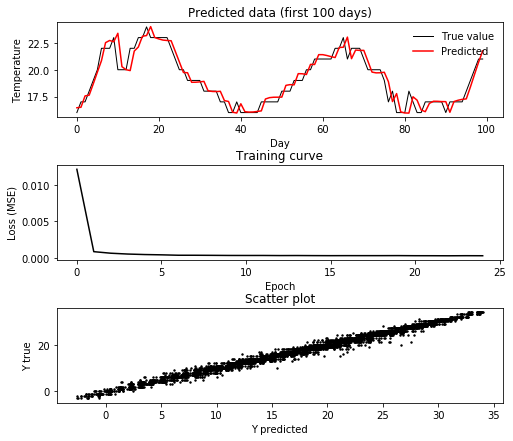

In [24]:
#Grafički prikatz rezultata
plt.figure(figsize=(8,7))


plt.subplot(3, 1, 1)
plt.plot(y_test_descaledSLSTM[0:100], color = 'black', linewidth=1, label = 'True value')
plt.plot(y_predicted_descaledSLSTM[0:100], color = 'red', label = 'Predicted')
plt.legend(frameon=False)
plt.ylabel("Temperature")
plt.xlabel("Day")
plt.title("Predicted data (first 100 days)")

plt.subplot(3, 1, 2)
plt.plot(epochs_num, loss, color='black')
plt.ylabel("Loss (MSE)")
plt.xlabel("Epoch")
plt.title("Training curve")

plt.subplot(3, 1, 3)
plt.scatter(y_predicted_descaledSLSTM, y_test_descaledSLSTM, s=2, color='black')
plt.ylabel("Y true")
plt.xlabel("Y predicted")
plt.title("Scatter plot")

plt.subplots_adjust(hspace =
                    0.5, wspace=0.3)

plt.savefig("tempPredictionSLSTM.png",  bbox_inches = "tight")


plt.show()

In [25]:
#Srednja kvadratna i srednja apsolutna greška 
mseSLSTM = metrics.mean_squared_error(y_test_descaledSLSTM, y_predicted_descaledSLSTM)
maeSLSTM = metrics.mean_absolute_error(y_test_descaledSLSTM, y_predicted_descaledSLSTM)
print("mse SLSTM=" + str(round(mseSLSTM,2)))
print("mae SLSTM=" + str(round(maeSLSTM,2)))

mse SLSTM=0.72
mae SLSTM=0.59


In [27]:
# Kreiranje i treniranje Bidirectional LSTM modela upotrebom Keras biblioteke
modelBLSTM = Sequential()
modelBLSTM.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(X_train.shape[1], X_train.shape[2])))
modelBLSTM.add(Dense(1))
modelBLSTM.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = modelBLSTM.fit(X_train, y_train, epochs = 25, batch_size = 36)
loss = history.history['loss']
epochs_num = range(len(loss))

Epoch 1/25
19056/19056 [==============================] - 32s 2ms/step - loss: 0.0068
Epoch 2/25
19056/19056 [==============================] - 31s 2ms/step - loss: 5.7573e-04
Epoch 3/25
19056/19056 [==============================] - 32s 2ms/step - loss: 4.3432e-04
Epoch 4/25
19056/19056 [==============================] - 32s 2ms/step - loss: 3.5740e-04
Epoch 5/25
19056/19056 [==============================] - 32s 2ms/step - loss: 3.3286e-04
Epoch 6/25
19056/19056 [==============================] - 33s 2ms/step - loss: 3.1815e-04
Epoch 7/25
19056/19056 [==============================] - 32s 2ms/step - loss: 3.1536e-04
Epoch 8/25
19056/19056 [==============================] - 31s 2ms/step - loss: 2.9936e-04
Epoch 9/25
19056/19056 [==============================] - 31s 2ms/step - loss: 2.8138e-04
Epoch 10/25
19056/19056 [==============================] - 32s 2ms/step - loss: 2.8123e-04
Epoch 11/25
19056/19056 [==============================] - 31s 2ms/step - loss: 2.7480e-04
Epoch 12/25


In [28]:
# Predikcija vrednosti na osnovu podataka za testiranje
y_predictedBLSTM = modelBLSTM.predict(X_test)

In [29]:
# Vracanje vrednosti u originalne vrednosti ('obrnuta normalizacija')
y_predicted_descaledBLSTM = sc.inverse_transform(y_predictedBLSTM)
y_train_descaledBLSTM = sc.inverse_transform(y_train)
y_test_descaledBLSTM = sc.inverse_transform(y_test)
y_predBLSTM = y_predictedBLSTM.ravel()
y_predBLSTM = [round(yx, 2) for yx in y_predBLSTM]
y_testedBLSTM = y_test.ravel()

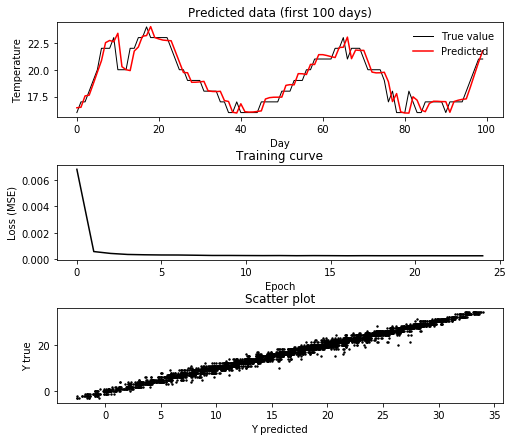

In [31]:
#Grafički prikatz rezultata
plt.figure(figsize=(8,7))


plt.subplot(3, 1, 1)
plt.plot(y_test_descaledBLSTM[0:100], color = 'black', linewidth=1, label = 'True value')
plt.plot(y_predicted_descaledSLSTM[0:100], color = 'red', label = 'Predicted')
plt.legend(frameon=False)
plt.ylabel("Temperature")
plt.xlabel("Day")
plt.title("Predicted data (first 100 days)")

plt.subplot(3, 1, 2)
plt.plot(epochs_num, loss, color='black')
plt.ylabel("Loss (MSE)")
plt.xlabel("Epoch")
plt.title("Training curve")

plt.subplot(3, 1, 3)
plt.scatter(y_predicted_descaledBLSTM, y_test_descaledBLSTM, s=2, color='black')
plt.ylabel("Y true")
plt.xlabel("Y predicted")
plt.title("Scatter plot")

plt.subplots_adjust(hspace =
                    0.5, wspace=0.3)

plt.savefig("tempPredictionBLSTM.png",  bbox_inches = "tight")


plt.show()

In [32]:
#Srednja kvadratna i srednja apsolutna greška 
mseBLSTM = metrics.mean_squared_error(y_test_descaledBLSTM, y_predicted_descaledBLSTM)
maeBLSTM = metrics.mean_absolute_error(y_test_descaledBLSTM, y_predicted_descaledBLSTM)
print("mse BLSTM=" + str(round(mseBLSTM,2)))
print("mae BLSTM=" + str(round(maeBLSTM,2)))

mse BLSTM=0.71
mae BLSTM=0.61
